# Repairing Code Automatically

So far, we have discussed how to track failures and how to locate defects in code. Let us now discuss how to _repair_ defects – that is, to correct the code such that the failure no longer occurs. We will discuss how to _repair code automatically_ – by systematically searching through possible fixes and evolving the most promising candidates.

In [1]:
from bookutils import YouTubeVideo
# YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* Re-read the [introduction to debugging](Intro_Debugging.ipynb), notably on how to properly fix code.
* We make use of automatic fault localization, as discussed in the [chapter on statistical debugging](StatisticalDebugger.ipynb).
* We make extensive use of code transformations, as discussed in [the chapter on tracing executions](Tracer.ipynb).
* We make use of [delta debugging](DeltaDebugger.ipynb).

In [2]:
import bookutils

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Repairer import <identifier>
```

and then make use of the following features.


We can repair things!



## Automatic Code Repairs

So far, we have discussed how to locate defects in code, how to track failures back to the defects that caused them, and how to systematically determine failure conditions. Let us now address the last step in debugging – namely, how to _automatically fix code_.

Already in the [introduction to debugging](Intro_Debugging.ipynb), we have discussed how to fix code manually. Notably, we have established that a _diagnosis_ (which induces a fix) should show _causality_ (i.e, how the defect causes the failure) and _incorrectness_ (how the defect is wrong). Is it possible to obtain such a diagnosis automatically?

In this chapter, we introduce a technique of _automatic code repair_ – that is, for a given failure, automatically determine a fix that makes the failure go away. To do so, we randomly (but systematically) _mutate_ the program code – that is, insert, change, and delete fragments – until we find a change that actually causes the failing test to pass.

If this sounds like an audacious idea, that is because it is. But not only is _automated program repair_ one of the hottest topics of software research in the last decade, it is also being increasingly deployed in industry. At Facebook, for instance, every failing test report comes with an automatically generated _repair suggestion_ – a suggestion that already has been validated to work. Programmers can apply the suggestion as is or use it as basis for their own fixes.

In this chapter, we use an ongoing example. In the [chapter on statistical debugging](StatisticalDebugger.ipynb), we have introduced the `middle()` function – a function that returns the "middle" of three numbers `x`, `y`, and `z`:

In [3]:
from StatisticalDebugger import middle

In [4]:
# ignore
from bookutils import print_content

In [5]:
# ignore
import inspect

In [6]:
# ignore
_, first_lineno = inspect.getsourcelines(middle)
middle_source = inspect.getsource(middle)
print_content(middle_source, '.py', start_line_number=first_lineno)

503  def middle(x, y, z):
504      if y < z:
505          if x < y:
506              return y
507          elif x < z:
508              return y
509      else:
510          if x > y:
511              return y
512          elif x > z:
513              return x
514      return z

In most cases, `middle()` just runs fine:

In [7]:
middle(4, 5, 6)

5

In some other cases, though, it does not work correctly:

In [8]:
middle(2, 1, 3)

1

Now, if we only want a repair that fixes this one given failure, this would be very easy. All we have to do is to replace the entire body by a single statement:

In [9]:
def middle_sort_of_fixed(x, y, z):
    return x

You will concur that the failure no longer occurs:

In [10]:
middle_sort_of_fixed(2, 1, 3)

2

But this, of course, is not the aim of automatic fixes, nor of fixes in general: We want our fixes not only to make the given failure go away, but we also want the resulting code to be _correct_ (which, of course, is a lot harder).

Automatic repair techniques therefore assume the existence of a _test suite_ that can check whether an implementation satisfies its requirements. Better yet, one can use the test suite to gradually check _how close_ one is to perfection: A piece of code that satisfies 99% of all tests is better than one that satisfies 33% of all tests, as `middle_sort_of_fixed()` would do.

The master plan for automatic repair is as follows:

1. Have a _test suite_ with both failing and passing tests that helps asserting correctness of possible solutions.
2. With the test suite, use [fault localization](StatisticalDebugger.ipynb) to determine potential code locations to be fixed.
3. Systematically _mutate_ the code (by adding, changing, or deleting code) to create possible fix candidates. Retain those mutations that satisfy more tests and evolve them further.
4. Repeat until a perfect fix is found, or until time resources are depleted.

Let us illustrate these steps in the following sections.

## A Test Suite

In automated repair, the larger and the more thorough the test suite, the higher the quality of the resulting fix (if any). Hence, if we want to repair `middle()` automatically, we need a good test suite – with good inputs, but also with good checks.

The function `middle_testcase()` returns a random input for `middle()`:

In [11]:
import random

In [12]:
def middle_testcase():
    x = random.randrange(10)
    y = random.randrange(10)
    z = random.randrange(10)
    return x, y, z

In [13]:
[middle_testcase() for i in range(5)]

[(9, 0, 5), (0, 1, 9), (9, 0, 9), (2, 9, 0), (4, 7, 2)]

The function `middle_test()` simply checks if `middle()` operates correctly – by placing `x`, `y`, and `z` in a list, sorting it, and taking the middle argument. If `middle()` fails, `middle_test()` raises an exception.

In [14]:
def middle_test(x, y, z):
    m = middle(x, y, z)
    assert m == sorted([x, y, z])[1]

In [15]:
middle_test(4, 5, 6)

In [16]:
from ExpectError import ExpectError

In [17]:
with ExpectError():
    middle_test(2, 1, 3)

Traceback (most recent call last):
  File "<ipython-input-17-ae2957225406>", line 2, in <module>
    middle_test(2, 1, 3)
  File "<ipython-input-14-6bd1639308bf>", line 3, in middle_test
    assert m == sorted([x, y, z])[1]
AssertionError (expected)


The function `middle_passing_testcase()` searches and returns a triple `x`, `y`, `z` that causes `middle_test()` to pass.

In [18]:
def middle_passing_testcase():
    while True:
        try:
            x, y, z = middle_testcase()
            _ = middle_test(x, y, z)
            return x, y, z
        except AssertionError:
            pass

In [19]:
(x, y, z) = middle_passing_testcase()
m = middle(x, y, z)
print(f"middle({x}, {y}, {z}) = {m}")

middle(1, 6, 1) = 1


The function `middle_failing_testcase()` does the same; but its triple `x`, `y`, `z` causes `middle_test()` to fail.

In [20]:
def middle_failing_testcase():
    while True:
        try:
            x, y, z = middle_testcase()
            _ = middle_test(x, y, z)
        except AssertionError:
            return x, y, z

In [21]:
(x, y, z) = middle_failing_testcase()
m = middle(x, y, z)
print(f"middle({x}, {y}, {z}) = {m}")

middle(5, 2, 6) = 2


With these, we can define two sets of test cases, each with 100 inputs.

In [22]:
MIDDLE_TESTS = 100

In [23]:
MIDDLE_PASSING_TESTCASES = [middle_passing_testcase()
                            for i in range(MIDDLE_TESTS)]

In [24]:
MIDDLE_FAILING_TESTCASES = [middle_failing_testcase()
                            for i in range(MIDDLE_TESTS)]

## Locating the Defect

Our next step is to find potential defect locations – that is, those locations in the code our mutations should focus upon. Since we already do have two test suites, we can make use of [statistical debugging](StatisticalDebugger.ipynb) to identify likely faulty locations.  Our `OchiaiDebugger` ranks individual code lines by how frequently they are executed in failing runs (and not in passing runs).

In [25]:
from StatisticalDebugger import OchiaiDebugger, CoverageCollector

In [26]:
debugger = OchiaiDebugger(CoverageCollector)

for x, y, z in MIDDLE_PASSING_TESTCASES:
    with debugger.collect_pass():
        m = middle(x, y, z)

for x, y, z in MIDDLE_FAILING_TESTCASES:
    with debugger.collect_fail():
        m = middle(x, y, z)

In [27]:
debugger

503  70% def middle(x, y, z):
 504  70%     if y < z:
 505  88%         if x < y:
 506   0%             return y
 507  90%         elif x < z:
 508  96%             return y
 509          else:
 510   0%         if x > y:
 511   0%             return y
 512   0%         elif x > z:
 513   0%             return x
 514   0%     return z

The most suspicious line is:

In [28]:
# ignore
location = debugger.rank()[0]
(func_name, lineno) = location
lines, first_lineno = inspect.getsourcelines(middle)
print(lineno, end="")
print_content(lines[lineno - first_lineno], '.py')

508            return y

and its suspiciousness is:

In [29]:
# ignore
debugger.suspiciousness(location)

0.9622504486493763

## Random Code Mutations

Our third step in automatic code repair is to _randomly mutate the code_. Specifically, we want to randomly _delete_, _insert_, and _replace_ statements in the program to be repaired. However, simply synthesizing code _from scratch_ is unlikely to yield anything meaningful – the number of combinations is simply far too high. Already for a three-character identifier name, we have more than 200,000 combinations:

In [30]:
import string

In [31]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [32]:
len(string.ascii_letters + '_') * \
  len(string.ascii_letters + '_' + string.digits) * \
  len(string.ascii_letters + '_' + string.digits)

210357

Hence, we do _not_ synthesize code from scratch, but instead _reuse_ elements from the program to be fixed, hypothesizing that "a program that contains an error in one area likely implements the correct behavior elsewhere" \cite{LeGoues2012}.

Furthermore, we do not operate on a _textual_ representation of the program, but rather on a _structural_ representation, which by construction allows us to avoid lexical and syntactical errors in the first place.

This structural representation is the _abstract syntax tree_ (AST), which we already have seen in various chapters, such as the [chapter on delta debugging](DeltaDebugger.ipynb), the [chapter on tracing](Tracer.ipynb), and excessively in the [chapter on slicing](Slicer.ipynb). The [official Python `ast` reference](http://docs.python.org/3/library/ast) is complete, but a bit brief; the documentation ["Green Tree Snakes - the missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/) provides an excellent introduction.

Recapitulating, an AST is a tree representation of the program, showing a hierarchical structure of the program's elements. Here is the AST for our `middle()` function.

In [33]:
import ast
import astor
import inspect

In [34]:
from bookutils import print_content, show_ast

In [35]:
def middle_tree():
    return ast.parse(inspect.getsource(middle))

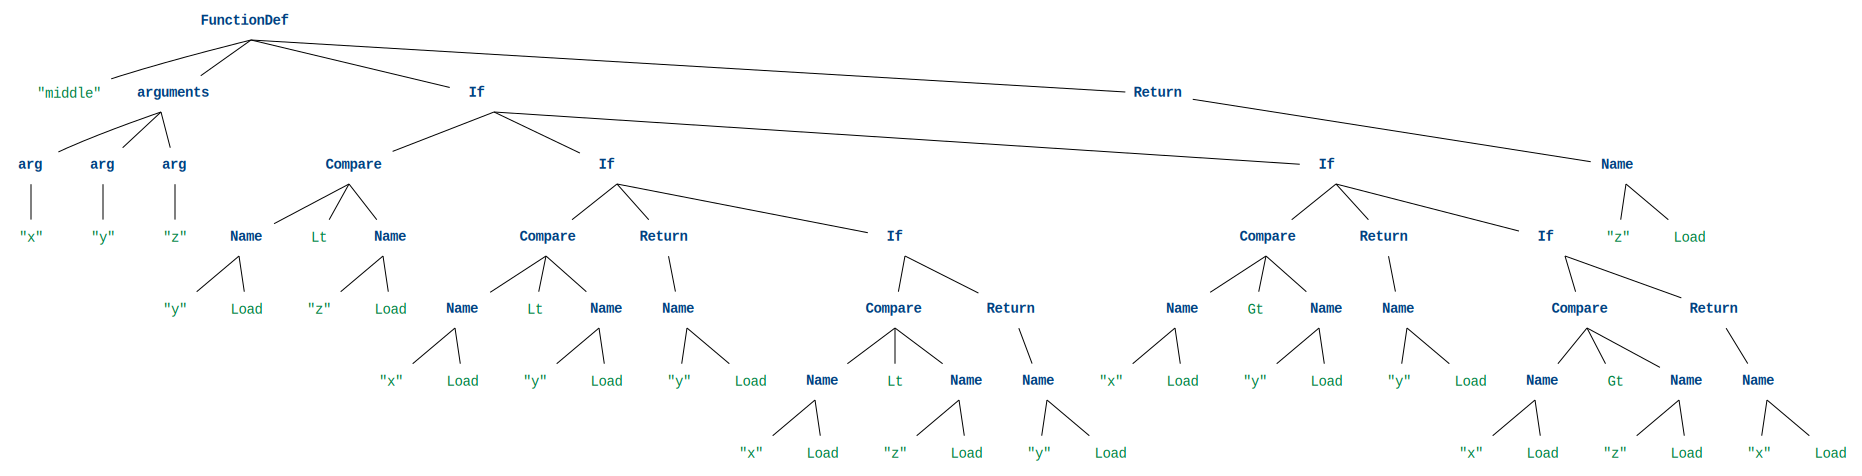

In [36]:
show_ast(middle_tree())

 You see that it consists of one function definition (`FunctionDef`) with three `arguments` and two statements – one `If` and one `Return`. Each `If` subtree has three branches – one for the condition (`test`), one for the body to be executed if the condition is true (`body`), and one for the `else` case (`orelse`). The `body` and `orelse` branches again are lists of statements.

An AST can also be shown as text, which is more compact, yet reveals more information. `ast.dump()` gives not only the class names of elements, but also how they are constructed – actually, the whole expression can be used to construct an AST.

In [37]:
print(ast.dump(middle_tree()))

Module(body=[FunctionDef(name='middle', args=arguments(args=[arg(arg='x', annotation=None), arg(arg='y', annotation=None), arg(arg='z', annotation=None)], vararg=None, kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[]), body=[If(test=Compare(left=Name(id='y', ctx=Load()), ops=[Lt()], comparators=[Name(id='z', ctx=Load())]), body=[If(test=Compare(left=Name(id='x', ctx=Load()), ops=[Lt()], comparators=[Name(id='y', ctx=Load())]), body=[Return(value=Name(id='y', ctx=Load()))], orelse=[If(test=Compare(left=Name(id='x', ctx=Load()), ops=[Lt()], comparators=[Name(id='z', ctx=Load())]), body=[Return(value=Name(id='y', ctx=Load()))], orelse=[])])], orelse=[If(test=Compare(left=Name(id='x', ctx=Load()), ops=[Gt()], comparators=[Name(id='y', ctx=Load())]), body=[Return(value=Name(id='y', ctx=Load()))], orelse=[If(test=Compare(left=Name(id='x', ctx=Load()), ops=[Gt()], comparators=[Name(id='z', ctx=Load())]), body=[Return(value=Name(id='x', ctx=Load()))], orelse=[])])]), Return(value=Name(id

This is the path to the first `return` statement:

In [38]:
ast.dump(middle_tree().body[0].body[0].body[0].body[0])

"Return(value=Name(id='y', ctx=Load()))"

### Picking Statements

For our mutation operators, we want to use statements from the program itself. Hence, we need a means to find those very statements. The `StatementVisitor` class iterates through an AST, adding all statements to its `statements` list it finds in function definitions. To do so, it subclasses the Python `ast` `NodeVisitor` class, described in the [official Python `ast` reference](http://docs.python.org/3/library/ast).

In [39]:
from ast import NodeVisitor

In [40]:
class StatementVisitor(NodeVisitor):
    """Visit all statements within function defs in an AST"""
    def __init__(self):
        self.statements = []
        self.func_name = None
        self.statements_seen = set()
        super().__init__()

    def add_statements(self, node, attr):
        elems = getattr(node, attr, [])
        if not isinstance(elems, list):
            elems = [elems]
            
        for elem in elems:
            stmt = (elem, self.func_name)
            if stmt in self.statements_seen:
                continue
                
            self.statements.append(stmt)
            self.statements_seen.add(stmt)

    def visit_node(self, node):
        # Any node other than the ones listed below
        self.add_statements(node, 'body')
        self.add_statements(node, 'orelse')

    def visit_Module(self, node):
        # Module children are defs, classes and globals - don't add
        super().generic_visit(node)

    def visit_ClassDef(self, node):
        # Class children are defs and globals - don't add
        super().generic_visit(node)

    def generic_visit(self, node):
        self.visit_node(node)
        super().generic_visit(node)
        
    def visit_FunctionDef(self, node):
        if self.func_name is None:
            self.func_name = node.name
        
        self.visit_node(node)
        super().generic_visit(node)
        self.func_name = None

    def visit_AsyncFunctionDef(self, node):
        return visit_FunctionDef(self, node)

The function `all_statements()` returns all statements in the given AST `tree`. If an `ast` class `tp` is given, it only returns instances of that class.

In [41]:
def all_statements_and_functions(tree, tp=None):
    visitor = StatementVisitor()
    visitor.visit(tree)
    statements = visitor.statements
    if tp is not None:
        statements = [s for s in statements if isinstance(s[0], tp)]

    return statements

In [42]:
def all_statements(tree, tp=None):
    return [stmt for stmt, func_name in all_statements_and_functions(tree, tp)]

Here are all the `return` statements in `middle()`:

In [43]:
all_statements(middle_tree(), ast.Return)

In [44]:
all_statements_and_functions(middle_tree(), ast.If)

[(<_ast.If at 0x7ffbbb3d9470>, 'middle'),
 (<_ast.If at 0x7ffbbb3d9710>, 'middle'),
 (<_ast.If at 0x7ffbbb275b00>, 'middle'),
 (<_ast.If at 0x7ffbbb275b38>, 'middle'),
 (<_ast.If at 0x7ffbbb266ba8>, 'middle')]

We can randomly pick an element:

In [45]:
import random

In [46]:
random_node = random.choice(all_statements(middle_tree()))
astor.to_source(random_node)

'return y\n'

### Mutating Statements

The main part in mutation, however, is to actually mutate the code of the program under test. To this end, we introduce a `StatementMutator` class – a subclass of `NodeTransformer`, described in the [official Python `ast` reference](http://docs.python.org/3/library/ast).

The constructor provides various keyword arguments to configure the mutator.

In [47]:
from ast import NodeTransformer

In [48]:
import copy

In [49]:
class StatementMutator(NodeTransformer):
    """Mutate statements in an AST for automated repair."""
    def __init__(self, suspiciousness_func=None, statements=None, log=False):
        """Constructor.
        `suspiciousness_func` is a function that takes a location 
        (function, line_number) and returns a suspiciousness value
        between 0 and 1.0. If not given, all locations get the 
        same suspiciousness.
        `statements` is a list of statements to choose from.
        """
        super().__init__()

        if suspiciousness_func is None:
            suspiciousness_func = lambda location: 1.0
        self.suspiciousness_func = suspiciousness_func

        if statements is None:
            statements = []
        self.statements = statements

        self.log = log

        self.mutations = 0

#### Choosing Nodes to Mutate

We start with deciding which AST nodes to mutate. The method `node_suspiciousness()` returns the suspiciousness for a given node, by invoking `suspiciousness_func`. Since a node only holds the current line number, but not a function name, we track this during the tree traversal.

In [50]:
import warnings

In [51]:
class StatementMutator(StatementMutator):
    def format_node(self, node):
        if node is None:
            return None
        if isinstance(node, list):
            return "; ".join(self.format_node(elem) for elem in node)

        s = RE_SPACE.sub(' ', astor.to_source(node)).strip()
        if len(s) > 20:
            s = s[:20] + "..."
        return repr(s)

    def node_suspiciousness(self, stmt, func_name):
        if not hasattr(stmt, 'lineno'):
            warnings.warn(f"{self.format_node(stmt)}: Expected line number")
            return 0.0

        suspiciousness = self.suspiciousness_func((func_name, stmt.lineno))
        if suspiciousness is None:  # not executed
            return 0.0

        return suspiciousness

The method `should_mutate()` chooses a node for mutation. The higher the suspiciousness, the higher the chance of a node to be mutated.

In [52]:
class StatementMutator(StatementMutator):
    def node_to_be_mutated(self, tree):
        statements = all_statements_and_functions(tree)
        assert len(statements) > 0, "No statements"

        weights = [self.node_suspiciousness(stmt, func_name) 
                   for stmt, func_name in statements]
        assert sum(weights) > 0, "No suspicious location"

        if self.log > 1:
            print("Weights:")
            for i, stmt in enumerate(statements):
                node, func_name = stmt
                print(f"{weights[i]:.2} {self.format_node(node)}")

        stmts = [stmt for stmt, func_name in statements]

        return random.choices(stmts, weights=weights)[0]

#### Choosing an Operator

For nodes chosen for mutation, the method `generic_visit()` randomly chooses a mutation method (`choose_op()`) and then invokes it on the node.

In [53]:
import re

In [54]:
RE_SPACE = re.compile(r'[ \t\n]+')

In [55]:
class StatementMutator(StatementMutator):
    def choose_op(self):
        return random.choice([self.insert, self.swap, self.delete])

    def visit(self, node):
        super().visit(node)  # Visits (and transforms?) children

        if not node.mutate_me:
            return node
        
        op = self.choose_op()
        new_node = op(node)
        self.mutations += 1

        if self.log:
            print(f"{node.lineno:4}:{op.__name__:6}: "
                  f"{self.format_node(node)} "
                  f"becomes {self.format_node(new_node)}")

        return new_node

#### Swapping Statements

In [56]:
class StatementMutator(StatementMutator):
    def choose_statement(self):
        return copy.deepcopy(random.choice(self.statements))

In [57]:
class StatementMutator(StatementMutator):
    def swap(self, node):
        # Replace with a random node from statements
        new_node = self.choose_statement()

        if isinstance(new_node, ast.stmt):
            # The source `if P: X` is added as `if P: pass`
            if hasattr(new_node, 'body'):
                new_node.body = [ast.Pass()]
            if hasattr(new_node, 'orelse'):
                new_node.orelse = []
            if hasattr(new_node, 'finalbody'):
                new_node.finalbody = []

        # ast.copy_location(new_node, node)
        return new_node

#### Inserting Statements

In [58]:
class StatementMutator(StatementMutator):
    def insert(self, node):
        # Insert a random node from statements
        new_node = self.choose_statement()

        if isinstance(new_node, ast.stmt) and hasattr(new_node, 'body'):
            # Inserting `if P: X` as `if P:`
            new_node.body = [node]
            if hasattr(new_node, 'orelse'):
                new_node.orelse = []
            if hasattr(new_node, 'finalbody'):
                new_node.finalbody = []
            # ast.copy_location(new_node, node)
            return new_node

        # Only insert before `return`, not after it
        if isinstance(node, ast.Return):
            if isinstance(new_node, ast.Return):
                return new_node
            else:
                return [new_node, node]

        return [node, new_node]

#### Deleting Statements

In [59]:
class StatementMutator(StatementMutator):
    def delete(self, node):
        # Delete this node

        branches = [attr for attr in ['body', 'orelse', 'finalbody']
                    if hasattr(node, attr) and getattr(node, attr)]
        if branches:
            # Replace `if P: S` by `S`
            branch = random.choice(branches)
            new_node = getattr(node, branch)
            return new_node

        if isinstance(node, ast.stmt):
            # Avoid empty bodies; make this a `pass` statement
            new_node = ast.Pass()
            ast.copy_location(new_node, node)
            return new_node

        return None  # Just delete

#### All Together

In [60]:
class StatementMutator(StatementMutator):
    def visit(self, node):
        if not self.statements:
            self.statements = all_statements(node)

        return super().visit(node)

In [61]:
class StatementMutator(StatementMutator):
    def mutate(self, tree):
        tree = copy.deepcopy(tree)
        for node in ast.walk(tree):
            node.mutate_me = False

        node = self.node_to_be_mutated(tree)
        node.mutate_me = True

        self.mutations = 0
        tree = self.visit(tree)

        if self.mutations == 0:
            warnings.warn("No mutations found")

        ast.fix_missing_locations(tree)
        return tree

In [62]:
mutator = StatementMutator(log=True)
for i in range(10):
    new_tree = mutator.mutate(middle_tree())

   9:insert: 'return y' becomes 'return y'
   8:insert: 'if x > y: return y e...' becomes 'if x < y: if x > y: ...'
  12:insert: 'return z' becomes 'if y < z: return z'
   3:swap  : 'if x < y: return y e...' becomes 'return x'
   3:swap  : 'if x < y: return y e...' becomes 'return z'
   3:swap  : 'if x < y: return y e...' becomes 'return x'
  11:swap  : 'return x' becomes 'return y'
  10:insert: 'if x > z: return x' becomes 'if x > z: return x'; 'return z'
  12:delete: 'return z' becomes 'pass'
   8:swap  : 'if x > y: return y e...' becomes 'if y < z: pass'


In [63]:
print_content(astor.to_source(new_tree), '.py')

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif y < z:
        pass
    return z

## Fitness

In [64]:
WEIGHT_PASSING = 0.99
WEIGHT_FAILING = 0.01

In [65]:
def middle_fitness(tree):
    original_middle = middle

    try:
        code = compile(tree, '<fitness>', 'exec')
    except ValueError:
        return 0  # Compilation error

    exec(code, globals())

    passing_passed = 0
    failing_passed = 0

    # Test how many of the passing runs pass
    for x, y, z in MIDDLE_PASSING_TESTCASES:
        try:
            middle_test(x, y, z)
            passing_passed += 1
        except AssertionError:
            pass

    passing_ratio = passing_passed / len(MIDDLE_PASSING_TESTCASES)

    # Test how many of the failing runs pass
    for x, y, z in MIDDLE_FAILING_TESTCASES:
        try:
            middle_test(x, y, z)
            failing_passed += 1
        except AssertionError:
            pass

    failing_ratio = failing_passed / len(MIDDLE_FAILING_TESTCASES)

    fitness = (WEIGHT_PASSING * passing_ratio +
               WEIGHT_FAILING * failing_ratio)

    globals()['middle'] = original_middle
    return fitness

In [66]:
middle_fitness(middle_tree())

0.99

In [67]:
middle_fitness(ast.parse("def middle(x, y, z): return z"))

0.495

In [68]:
from StatisticalDebugger import middle_fixed

In [69]:
middle_fixed_source = \
    inspect.getsource(middle_fixed).replace('middle_fixed', 'middle').strip()

In [70]:
middle_fitness(ast.parse(middle_fixed_source))

1.0

## Population

In [71]:
POPULATION_SIZE = 50
mutator = StatementMutator()

In [72]:
MIDDLE_POPULATION = [middle_tree()] + \
    [mutator.mutate(middle_tree()) for i in range(POPULATION_SIZE - 1)]

In [73]:
MIDDLE_POPULATION.sort(key=middle_fitness, reverse=True)

Highest fitness:

In [74]:
print(astor.to_source(MIDDLE_POPULATION[0]), 
      middle_fitness(MIDDLE_POPULATION[0]))

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif x > y:
        return y
    elif x > z:
        return x
    return z
 0.99


Lowest fitness:

In [75]:
print(astor.to_source(MIDDLE_POPULATION[-1]), 
      middle_fitness(MIDDLE_POPULATION[-1]))

def middle(x, y, z):
    if x < y:
        return y
    elif x < z:
        return y
    return z
 0.3564


## Evolution

In [76]:
def evolve_middle():
    global MIDDLE_POPULATION

    statements = all_statements(middle_tree())
    mutator = StatementMutator(statements=statements)

    n = len(MIDDLE_POPULATION)

    MIDDLE_POPULATION.sort(key=middle_fitness, reverse=True)
    MIDDLE_POPULATION = MIDDLE_POPULATION[:n // 2]

    offspring = [mutator.mutate(tree) for tree in MIDDLE_POPULATION]

    MIDDLE_POPULATION += offspring

In [77]:
evolve_middle()

In [78]:
tree = MIDDLE_POPULATION[0]
print(astor.to_source(tree), middle_fitness(tree))

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif x > y:
        return y
    elif x > z:
        return x
    return z
 0.99


In [79]:
for i in range(50):
    evolve_middle()
    best_tree = MIDDLE_POPULATION[0]
    fitness = middle_fitness(best_tree)
    print(f"\rIteration {i:2}: fitness = {fitness}  ", end="")
    if fitness >= 1.0:
        break

Iteration  6: fitness = 1.0  

In [80]:
print_content(astor.to_source(best_tree), '.py')

def middle(x, y, z):
    if y < z:
        if x < y:
            pass
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

## Simplifying

### Textual Reduction

We could use `DeltaDebugger` on code to minimize the whole thing.

In [81]:
from DeltaDebugger import DeltaDebugger

In [82]:
middle_lines = astor.to_source(best_tree).split('\n')

In [83]:
def test_middle_lines(lines):
    source = "\n".join(lines)
    tree = ast.parse(source)
    assert middle_fitness(tree) < 1.0  # "Fail" only while fitness is 1.0

In [84]:
with DeltaDebugger() as dd:
    test_middle_lines(middle_lines)

In [85]:
reduced_source = "\n".join(dd.min_args()['lines'])
repaired_source = astor.to_source(ast.parse(reduced_source))  # normalize
print_content(repaired_source, '.py')

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

We can present the difference to the original as a patch:

In [86]:
original_source = astor.to_source(middle_tree())

In [87]:
from ChangeDebugger import diff

In [88]:
import urllib

In [89]:
def print_patch(p):
    print_content(urllib.parse.unquote(str(p)), '.py')

In [90]:
for patch in diff(original_source, repaired_source):
    print_patch(patch)

@@ -87,37 +87,37 @@
  x < z:

-            return y

+            return x

     elif

## Crossover

Pick two ASTs. Pick two functions. Do a crossover on any body sequence.

In [91]:
def p1():
    def inner():
        print(a)
        print(b)
        print(c)

    a = 1
    b = 2
    c = 3

In [92]:
def p2():
    def inner():
        print(x)
        print(y)
        print(z)

    x = 1
    y = 2
    z = 3

In [93]:
class BodyCrossover:
    def __init__(self, log=False):
        self.log = log

    def cross_bodies(self, body_1, body_2):
        """Crossover the statement lists `body_1` x `body_2`.
        Return new lists.
        """

        assert isinstance(body_1, list)
        assert isinstance(body_2, list)

        split_1 = len(body_1) // 2
        split_2 = len(body_2) // 2
        return body_1[:split_1] + body_2[split_2:], body_2[:split_2] + body_1[split_1:]

In [94]:
tree_p1 = ast.parse(inspect.getsource(p1))
tree_p2 = ast.parse(inspect.getsource(p2))

In [95]:
body_p1 = tree_p1.body[0].body
body_p2 = tree_p2.body[0].body
body_p1

In [96]:
crosser = BodyCrossover()
tree_p1.body[0].body, tree_p2.body[0].body = crosser.cross_bodies(body_p1, body_p2)

In [97]:
print_content(astor.to_source(tree_p1), '.py')

def p1():

    def inner():
        print(a)
        print(b)
        print(c)
    a = 1
    y = 2
    z = 3

In [98]:
print_content(astor.to_source(tree_p2), '.py')

def p2():

    def inner():
        print(x)
        print(y)
        print(z)
    x = 1
    b = 2
    c = 3

In [99]:
class BodyCrossover(BodyCrossover):
    # In modules and class defs, the ordering of elements does not matter (much)
    SKIP_LIST = {ast.Module, ast.ClassDef}

    def can_cross(self, tree, body_attr='body'):
        if any(isinstance(tree, cls) for cls in self.SKIP_LIST):
            return False

        body = getattr(tree, body_attr, [])
        return body and len(body) >= 2

In [100]:
class BodyCrossover(BodyCrossover):
    def crossover_attr(self, t1, t2, body_attr):
        """Crossover the bodies `body_attr` of two trees `t1` and `t2`.
        Return True if successful."""
        assert isinstance(t1, ast.AST)
        assert isinstance(t2, ast.AST)
        assert isinstance(body_attr, str)

        if not getattr(t1, body_attr, None) or not getattr(t2, body_attr, None):
            return False

        body_1 = getattr(t1, body_attr)
        body_2 = getattr(t2, body_attr)

        # print(f"t1.{body_attr} = {body_1}")
        # print(f"t2.{body_attr} = {body_2}")

        # If both trees have the attribute, we can cross their bodies
        if self.can_cross(t1, body_attr) and self.can_cross(t2, body_attr):
            if self.log:
                print(f"Crossing {t1}.{body_attr} and {t2}.{body_attr}")

            new_body_1, new_body_2 = self.cross_bodies(body_1, body_2)
            setattr(t1, body_attr, new_body_1)
            setattr(t2, body_attr, new_body_2)
            return True

        # Strategy 1: Find matches in class/function of same name
        for child_1 in body_1:
            if hasattr(child_1, 'name'):
                for child_2 in body_2:
                    if (hasattr(child_2, 'name') and
                           child_1.name == child_2.name):
                        if self.crossover(child_1, child_2):
                            return True

        # Strategy 2: Find matches anywhere
        for child_1 in random.sample(body_1, len(body_1)):
            for child_2 in random.sample(body_2, len(body_2)):
                if self.crossover(child_1, child_2):
                    return True

        return False

In [101]:
class BodyCrossover(BodyCrossover):
    def crossover_branches(self, t1, t2):
        """Special case:
        `t1` = `if P: S1 else: S2` x `t2` = `if P': S1' else: S2'`
        becomes
        `t1` = `if P: S2' else: S1'` and `t2` = `if P': S2 else: S1`
        Returns True if successful.
        """
        assert isinstance(t1, ast.AST)
        assert isinstance(t2, ast.AST)
        
        if (hasattr(t1, 'body') and hasattr(t1, 'orelse') and
            hasattr(t2, 'body') and hasattr(t2, 'orelse')):
            t1.body, t1.orelse, t2.body, t2.orelse = \
                t2.orelse, t2.body, t2.orelse, t1.body
            return True

        return False

In [102]:
class CrossoverError(ValueError):
    pass

In [103]:
class BodyCrossover(BodyCrossover):
    def crossover(self, t1, t2):
        """Do a crossover of ASTs `t1` and `t2`.
        Raises `CrossoverError` if no crossover is found."""
        assert isinstance(t1, ast.AST)
        assert isinstance(t2, ast.AST)

        if self.crossover_branches(t1, t2):
            return t1, t2

        for body_attr in ['body', 'orelse', 'finalbody']:
            if self.crossover_attr(t1, t2, body_attr):
                return t1, t2

        raise CrossoverError("No crossover found")

In [104]:
def p1():
    if True:
        print(1)
        print(2)
        print(3)

In [105]:
def p2():
    if True:
        print(a)
        print(b)
    if False:
        print(c)
        print(d)

In [106]:
crossover = BodyCrossover(log=True)
tree_p1 = ast.parse(inspect.getsource(p1))
tree_p2 = ast.parse(inspect.getsource(p2))
crossover.crossover(tree_p1, tree_p2)

(<_ast.Module at 0x7ffbbb416400>, <_ast.Module at 0x7ffbbb4fccf8>)

In [107]:
print_content(astor.to_source(tree_p1), '.py')

def p1():
    if True:
    else:
        print(a)
        print(b)

In [108]:
print_content(astor.to_source(tree_p2), '.py')

def p2():
    if True:
    else:
        print(1)
        print(2)
        print(3)
    if False:
        print(c)
        print(d)

## A Repairer Class

In [109]:
class RobustCoverageCollector(CoverageCollector):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.exception_type = None

    def __exit__(self, tp, value, traceback):
        """Called at end of `with` block. Turn tracing off."""
        super().__exit__(tp, value, traceback)
        self.exception_type = tp
        return True  # ignore exception

In [110]:
class Repairer(OchiaiDebugger):
    def __init__(self, *args, **kwargs):
        self.fitness_cache = {}
        return super().__init__(RobustCoverageCollector, *args, **kwargs)

### Running Tests

In [111]:
class FailureNotReproducedError(ValueError):
    pass

In [112]:
class Repairer(Repairer):
    def run_test_set(self, test_set, validate=False):
        passed = 0
        collectors = self.collectors[test_set]
        function = globals()[self.function().__name__]  # may be redefined

        for c in collectors:
            if self.log >= 4:
                print(f"Testing {c.id()}...", end="")

            try:
                function(**c.args())
            except Exception as err:
                if self.log >= 4:
                    print(f"failed ({err.__class__.__name__})")

                if validate and test_set == self.PASS:
                    raise err(
                        f"{c.id()} should have passed, but failed")
                continue

            passed += 1
            if self.log >= 4:
                print("passed")

            if validate and test_set == self.FAIL:
                raise FailureNotReproducedError(
                    f"{c.id()} should have failed, but passed")

        return passed

In [113]:
class Repairer(Repairer):
    def weight(self, test_set):
        return {
            self.PASS: WEIGHT_PASSING,
            self.FAIL: WEIGHT_FAILING
        }[test_set]

    def run_tests(self, validate=False):
        # Run tests
        fitness = 0

        for test_set in [self.PASS, self.FAIL]:
            passed = self.run_test_set(test_set, validate=validate)
            ratio = passed / len(self.collectors[test_set])
            fitness += self.weight(test_set) * ratio

        return fitness

In [114]:
class DefinitionVisitor(NodeVisitor):
    def __init__(self):
        self.definitions = []

    def add_definition(self, node):
        self.definitions.append(node.name)

    def visit_FunctionDef(self, node):
        self.add_definition(node)

    def visit_AsyncFunctionDef(self, node):
        self.add_definition(node)

    def visit_Class(self, node):
        self.add_definition(node)

In [115]:
class Repairer(Repairer):
    def toplevel_defs(self, tree):
        visitor = DefinitionVisitor()
        visitor.visit(tree)
        return visitor.definitions

### (Re)defining Functions

In [116]:
class Repairer(Repairer):
    def fitness(self, tree):
        key = ast.dump(tree)
        if key in self.fitness_cache:
            return self.fitness_cache[key]

        # Save defs
        original_defs = {}
        for name in self.toplevel_defs(tree):
            original_defs[name] = globals()[name]

        if self.log >= 3:
            print("Repair candidate:")
            print_content(astor.to_source(tree), '.py')
            print()

        # Create new definition
        try:
            code = compile(tree, '<Repairer>', 'exec')
        except ValueError:  # Compilation error
            if self.log >= 3:
                print(f"Fitness = 0 (compilation error)")

            fitness = 0
            return fitness

        exec(code, globals())

        fitness = self.run_tests(validate=False)

        for name in original_defs:
            globals()[name] = original_defs[name]

        if self.log >= 3:
            print(f"Fitness = {fitness}")

        self.fitness_cache[key] = fitness
        return fitness

In [117]:
class Repairer(Repairer):
    def validate(self):
        fitness = self.run_tests(validate=True)
        assert fitness == self.weight(self.PASS)

### Repairing

In [118]:
class Repairer(Repairer):
    def getsource(self, item):
        if isinstance(item, str):
            item = globals()[item]
        return inspect.getsource(item)

In [119]:
class Repairer(Repairer):
    def repair(self, targets=None, sources=None, 
               population_size=POPULATION_SIZE,
               iterations=100, 
               mutator_cls=StatementMutator, mutator=None, 
               crossover_cls=BodyCrossover, crossover=None):
        """Repair the function test runs collected from.
        `targets`: a list of functions/modules to be repaired.
        (default: covered functions)
        `sources`: a list of functions/modules to take repairs from.
        (default: `targets`)
        """
        if targets is None:
            targets = self.default_functions()
        if not targets:
            raise ValueError("No targets to repair")

        if sources is None:
            sources = self.default_functions()
        if not sources:
            raise ValueError("No sources to take repairs from")

        if self.function() is None:
            raise ValueError("Multiple entry points observed")
            
        target_tree = self.parse(targets)
        source_tree = self.parse(sources)

        self.log_tree("Target code to be repaired:", target_tree)
        if ast.dump(target_tree) != ast.dump(source_tree):
            self.log_tree("Source code to take repairs from:", source_tree)

        self.validate()

        if mutator is None:
            statements = all_statements(source_tree)
            mutator = mutator_cls(statements=statements, 
                                  suspiciousness_func=self.suspiciousness,
                                  log=(self.log >= 3))
        if crossover is None:
            crossover = crossover_cls()

        population = [target_tree] + \
            [mutator.mutate(copy.deepcopy(target_tree))
                for i in range(population_size)]

        last_key = ast.dump(target_tree)

        for iteration in range(iterations):
            population = self.evolve(population, mutator, crossover)

            best_tree = population[0]
            fitness = self.fitness(best_tree)

            if self.log:
                print(f"Evolving population: "
                      f"iteration{iteration:4}/{iterations} "
                      f"fitness = {fitness:.5}   \r", end="")

            if self.log >= 2:
                best_key = ast.dump(best_tree)
                if best_key != last_key:
                    print()
                    print()
                    self.log_tree(f"New best code (fitness = {fitness}):",
                                  best_tree)
                    last_key = best_key

            if fitness >= 1.0:
                break

        if self.log:
            print()

        if self.log and self.log < 2:
            self.log_tree(f"Best code (fitness = {fitness}):", best_tree)

        best_tree = self.reduce(best_tree)
        fitness = self.fitness(best_tree)

        self.log_tree(f"Reduced code (fitness = {fitness}):", best_tree)

        return best_tree, fitness

### Evolving

In [120]:
class Repairer(Repairer):
    def evolve(self, population, mutator, crossover):
        n = len(population)

        population.sort(key=self.fitness, reverse=True)
        population = population[:n // 2]

        offspring = [mutator.mutate(tree) for tree in population]
        population += offspring

        return population

In [121]:
class Repairer(Repairer):
    def fitness_key(self, tree):
        tree_size = len([node for node in ast.walk(tree)])
        return (self.fitness(tree), -tree_size)

In [122]:
class Repairer(Repairer):
    def evolve(self, population, mutator, crossover):
        n = len(population)

        # Keep the fitter half of the population
        population.sort(key=self.fitness_key, reverse=True)
        population = population[:n // 2]

        # Create offspring as crossover of parents
        offspring = []
        while len(offspring) < n // 2:
            parent_1 = copy.deepcopy(random.choice(population))
            parent_2 = copy.deepcopy(random.choice(population))
            try:
                crossover.crossover(parent_1, parent_2)
                offspring += [parent_1, parent_2]
            except CrossoverError:
                # Try different parents
                pass

        # Mutate offspring
        offspring = [mutator.mutate(tree) for tree in offspring]
        population += offspring

        return population

### Reducing

In [123]:
class Repairer(Repairer):
    def test_reduce(self, lines, original_fitness):
        source = "\n".join(lines)
        tree = ast.parse(source)
        assert self.fitness(tree) < original_fitness

    def reduce(self, tree):
        original_fitness = self.fitness(tree)
        source_lines = astor.to_source(tree).split('\n')

        with DeltaDebugger() as dd:
            self.test_reduce(source_lines, original_fitness)

        reduced_source = "\n".join(dd.min_args()['lines'])
        return ast.parse(reduced_source)

### Helper Functions

In [124]:
class Repairer(Repairer):
    def default_functions(self):
        def is_test(name):
            return name.startswith('test') or name.endswith('test')

        return [name for name in self.covered_functions()
                if not is_test(name)]

    def log_tree(self, description, tree):
        if self.log:
            print(description)
            print_content(astor.to_source(tree), '.py')
            print()
            print()
            
    def parse(self, names):
        tree = ast.parse("")
        for name in names:
            item = globals()[name]
            item_lines, item_first_lineno = inspect.getsourcelines(item)
            item_tree = ast.parse("".join(item_lines))
            ast.increment_lineno(item_tree, item_first_lineno - 1)
            tree.body += item_tree.body

        return tree

### Repairer in Action

In [125]:
repairer = Repairer(log=2)

In [126]:
for x, y, z in MIDDLE_PASSING_TESTCASES:
    with repairer.collect_pass():
        m = middle_test(x, y, z)

In [127]:
for x, y, z in MIDDLE_FAILING_TESTCASES:
    with repairer.collect_fail():
        m = middle_test(x, y, z)

In [128]:
print(repairer.code(function=middle, suspiciousness=True))

 503  70% def middle(x, y, z):
 504  70%     if y < z:
 505  88%         if x < y:
 506   0%             return y
 507  90%         elif x < z:
 508  96%             return y
 509          else:
 510   0%         if x > y:
 511   0%             return y
 512   0%         elif x > z:
 513   0%             return x
 514   0%     return z



In [129]:
# repairer  # FIXME

In [130]:
repairer.suspiciousness(('middle', 508))

0.9622504486493763

In [131]:
best_tree, fitness = repairer.repair()

Target code to be repaired:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif x > y:
        return y
    elif x > z:
        return x
    return z

Evolving population: iteration   0/100 fitness = 1.0   

New best code (fitness = 1.0):
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z


Reduced code (fitness = 1.0):
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z



In [132]:
print_content(astor.to_source(best_tree), '.py')

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

In [133]:
fitness

1.0

## More Examples

### Removing HTML Markup

In [134]:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [135]:
def remove_html_markup_tree():
    return ast.parse(inspect.getsource(remove_html_markup))

In [136]:
def remove_html_markup_test(html, plain):
    outcome = remove_html_markup(html)
    assert outcome == plain, \
        f"Got {repr(outcome)}, expected {repr(plain)}"

In [137]:
globals()['remove_html_markup_test']

<function __main__.remove_html_markup_test(html, plain)>

In [138]:
remove_html_markup_test('<foo>bar</foo>', 'bar')

In [139]:
from ExpectError import ExpectError

In [140]:
with ExpectError():
    remove_html_markup_test('<foo>"bar"</foo>', '"bar"')

Traceback (most recent call last):
  File "<ipython-input-140-ab8b69125260>", line 2, in <module>
    remove_html_markup_test('<foo>"bar"</foo>', '"bar"')
  File "<ipython-input-136-a492611f8c18>", line 4, in remove_html_markup_test
    f"Got {repr(outcome)}, expected {repr(plain)}"
AssertionError: Got 'bar', expected '"bar"' (expected)


In [141]:
def random_string(length=5, start=ord(' '), end=ord('~')):
    return "".join(chr(random.randrange(start, end + 1)) for i in range(length))

In [142]:
random_string()

'GvKo7'

In [143]:
def random_id(length=2):
    return random_string(start=ord('a'), end=ord('z'))

In [144]:
random_id()

'flcsp'

In [145]:
def random_plain():
    return random_string().replace('<', '').replace('>', '')

In [146]:
def random_string_noquotes():
    return random_string().replace('"', '').replace("'", '')

In [147]:
def random_html(depth=0):
    prefix = random_plain()
    tag = random_id()

    if depth > 0:
        html, plain = random_html(depth - 1)
    else:
        html = plain = random_plain()

    attr = random_id()
    value = '"' + random_string_noquotes() + '"'
    postfix = random_plain()

    return f'{prefix}<{tag} {attr}={value}>{html}</{tag}>{postfix}', \
        prefix + plain + postfix

In [148]:
random_html()

('TU&-r<huywb zwbsw="(s)HG">36)=s</huywb>SR w7', 'TU&-r36)=sSR w7')

In [149]:
def remove_html_testcase(expected=True):
    while True:
        html, plain = random_html()
        outcome = (remove_html_markup(html) == plain)
        if outcome == expected:
            return html, plain

In [150]:
REMOVE_HTML_PASSING_TESTCASES = \
    [remove_html_testcase(True) for i in range(100)]
REMOVE_HTML_FAILING_TESTCASES = \
    [remove_html_testcase(False) for i in range(100)]

In [151]:
REMOVE_HTML_PASSING_TESTCASES[0]

('b%,F$<zeyak mwoyi="<bB>*">5N2_I</zeyak>-.TN)', 'b%,F$5N2_I-.TN)')

In [152]:
REMOVE_HTML_FAILING_TESTCASES[0]

('3AGe<qcguk yewyq="wA^<S">7"!%H</qcguk>6azh_', '3AGe7"!%H6azh_')

In [153]:
for html, plain in REMOVE_HTML_FAILING_TESTCASES:
    try:
        remove_html_markup_test(html, plain)
        assert False
    except:
        pass

In [154]:
for html, plain in REMOVE_HTML_PASSING_TESTCASES:
    remove_html_markup_test(html, plain)

In [155]:
repairer = Repairer(log=2)

In [156]:
for html, plain in REMOVE_HTML_PASSING_TESTCASES:
    with repairer.collect_pass():
        remove_html_markup_test(html, plain)

In [157]:
for html, plain in REMOVE_HTML_FAILING_TESTCASES:
    with repairer.collect_fail():
        remove_html_markup_test(html, plain)

In [158]:
from IPython.display import HTML

In [159]:
with ExpectError():
    repairer.code()  # FIXME

Traceback (most recent call last):
  File "<ipython-input-159-2cfddbf9b356>", line 2, in <module>
    repairer.code()  # FIXME
  File "StatisticalDebugger.ipynb", line 384, in code
    function = globals()[function]
KeyError: 'remove_html_markup_test' (expected)


In [160]:
HTML(repairer.code(function=remove_html_markup, color=True))

In [161]:
best_tree, fitness = repairer.repair()

Target code to be repaired:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

Evolving population: iteration  99/100 fitness = 0.99   
Reduced code (fitness = 0.99):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out



## Mutate Conditions

In [162]:
class ConditionVisitor(NodeVisitor):
    def __init__(self):
        self.conditions = []
        self.conditions_seen = set()
        super().__init__()

    def add_conditions(self, node, attr):
        elems = getattr(node, attr, [])
        if not isinstance(elems, list):
            elems = [elems]

        for elem in elems:
            elem_str = astor.to_source(elem)
            if elem_str not in self.conditions_seen:
                self.conditions.append(elem)
                self.conditions_seen.add(elem_str)

    def visit_BoolOp(self, node):
        self.add_conditions(node, 'values')
        return super().generic_visit(node)

    def visit_UnaryOp(self, node):
        if isinstance(node.op, ast.Not):
            self.add_conditions(node, 'operand')
        return super().generic_visit(node)

    def generic_visit(self, node):
        if hasattr(node, 'test'):
            self.add_conditions(node, 'test')
        return super().generic_visit(node)

In [163]:
def all_conditions(trees, tp=None):
    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]

    visitor = ConditionVisitor()
    for tree in trees:
        visitor.visit(tree)
    conditions = visitor.conditions
    if tp is not None:
        conditions = [c for c in conditions if isinstance(c, tp)]

    return conditions

In [164]:
[astor.to_source(cond).strip() for cond in all_conditions(remove_html_markup_tree())]

["(c == '<' and not quote)",
 "c == '<'",
 'not quote',
 'quote',
 "(c == '>' and not quote)",
 "c == '>'",
 '(c == \'"\' or c == "\'" and tag)',
 'c == \'"\'',
 'c == "\'" and tag',
 'c == "\'"',
 'tag',
 '(not tag)']

In [165]:
class ConditionMutator(StatementMutator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conditions = all_conditions(self.statements)
        if self.log:
            print("Found conditions",
                  [astor.to_source(cond).strip() for cond in self.conditions])

    def choose_condition(self):
        return copy.deepcopy(random.choice(self.conditions))

In [166]:
class ConditionMutator(ConditionMutator):
    def choose_bool_op(self):
        return random.choice(['set', 'not', 'and', 'or'])

    def swap(self, node):
        if not hasattr(node, 'test'):
            return super().swap(node)

        c1 = self.choose_condition()
        c2 = self.choose_condition()
        new_test = None

        choice = self.choose_bool_op()

        if choice == 'set':
            new_test = c1
        elif choice == 'not':
            new_test = ast.UnaryOp(op=ast.Not(), operand=c1)
        elif choice == 'and':
            new_test = ast.BoolOp(op=ast.And(), values=[c1, c2])
        elif choice == 'or':
            new_test = ast.BoolOp(op=ast.Or(), values=[c1, c2])
        else:
            raise ValueError("Unknown boolean operand")

        if new_test:
            # ast.copy_location(new_test, node)
            node.test = new_test

        return node

In [167]:
mutator = ConditionMutator(
    statements=all_statements(remove_html_markup_tree()), log=True)

Found conditions ["(c == '<' and not quote)", "c == '<'", 'not quote', 'quote', "(c == '>' and not quote)", "c == '>'", '(c == \'"\' or c == "\'" and tag)', 'c == \'"\'', 'c == "\'" and tag', 'c == "\'"', 'tag', '(not tag)']


In [168]:
new_tree = mutator.mutate(remove_html_markup_tree())

   7:delete: "if c == '<' and not ..." becomes 'tag = True'


In [169]:
repairer = Repairer(log=2)

In [170]:
for html, plain in REMOVE_HTML_PASSING_TESTCASES:
    with repairer.collect_pass():
        remove_html_markup_test(html, plain)

In [171]:
for html, plain in REMOVE_HTML_FAILING_TESTCASES:
    with repairer.collect_fail():
        remove_html_markup_test(html, plain)

In [172]:
repairer.repair(mutator_cls=ConditionMutator)

Target code to be repaired:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

Evolving population: iteration  23/100 fitness = 1.0   

New best code (fitness = 1.0):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif tag and c == '"':
            quote = not quote
        elif not tag:
            out = out + c
    return out


Reduced code (fitness = 1.0):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif

(<_ast.Module at 0x7ffbbb321160>, 1.0)

## Synopsis

We can repair things!

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

To learn more about automated program repair, see [program-repair.org](http://program-repair.org), the community page dedicated to research in program repair.  Also check out the [GenProg project page](https://squareslab.github.io/genprog-code/).

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [173]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [174]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_

In [175]:
class PrunePassTransformer(NodeTransformer):
    def prune_pass(self, body):
        if not body:
            return body

        # Get rid of `pass` statements
        new_body = list(filter(lambda stmt: not isinstance(stmt, ast.Pass), body))
        if len(new_body) == 0:
            # Oops – we need at least one `pass`
            new_node = ast.Pass()
            ast.copy_location(new_node, body[0])
            new_body = [new_node]

        return new_body
    
    def visit_node(self, node):
        if hasattr(node, 'body'):
            node.body = self.prune_pass(node.body)
        if hasattr(node, 'orelse'):
            node.orelse = self.prune_pass(node.orelse)
        return node

    def generic_visit(self, node):
        node = super().generic_visit(node)
        return self.visit_node(node)

In [176]:
prune_passes = PrunePassTransformer()
prune_passes.visit(best_tree)
print_content(astor.to_source(best_tree), '.py')

def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

In [177]:
class PruneReturnTransformer(NodeTransformer):
    def ends_in_return(self, body):
        return len(body) > 0 and isinstance(body[-1], ast.Return)

    def prune_returns(self, body):
        if body is None:
            return None

        # Get rid of statements after `return`
        for i, stmt in enumerate(body):
            if isinstance(stmt, ast.Return):
                body = body[:i + 1]
                break
            if isinstance(stmt, ast.If):
                body_returns = self.ends_in_return(stmt.body)
                orelse_returns = self.ends_in_return(stmt.orelse)
                if body_returns and orelse_returns:
                    body = body[:i + 1]
                    break

        return body

    def visit_node(self, node):
        if hasattr(node, 'body'):
            node.body = self.prune_returns(node.body)
        if hasattr(node, 'orelse'):
            node.orelse = self.prune_returns(node.orelse)
        return node

    def generic_visit(self, node):
        node = super().generic_visit(node)
        return self.visit_node(node)

In [178]:
prune_returns = PruneReturnTransformer()
prune_returns.visit(best_tree)
print_content(astor.to_source(best_tree), '.py')

def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out